# 5. Parallelism


In [1]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.types import Command
from langgraph.constants import Send
from typing import TypedDict, Literal
from typing_extensions import Annotated
import operator

In [2]:
llm = AzureChatOpenAI(model="gpt-4.1-mini")

In [3]:
class OurCustomState(TypedDict):
    animals: list[str]
    jokes: Annotated[list, operator.add]

class JokeState(TypedDict):
    subject: str

In [4]:
def joke_generator(state:JokeState) -> str:
    print("Node: Joke")
    response = llm.invoke(input=[HumanMessage(content=f"Tell me a joke about {state['subject']}. Only return the joke, nothing else.")])

    return {
        "jokes": [response.content]
    }

In [5]:
def random_animal_generator(state: OurCustomState) -> Command[Literal["joke_generator", "final_node"]]:
    print("Node: Random Animal")
    response = llm.invoke(input="Return 3 random animal names, comma separated.")
    animals = response.content.split(",")
    if len(animals) > 0:
        return Command(
            update={
                "animals": animals
            },
            goto=[
                Send(
                    node = "joke_generator",
                    arg = {
                        "subject": animal.strip()
                    }
                )
            for animal in animals]
        )
    else:
        return Command(
            update={
                "animals": []
            },
            goto=["final_node"]
        )

In [6]:
def final_node(state: OurCustomState):
    print("Node: Final")
    print("Animals:", state["animals"])
    print("Jokes:", state["jokes"])
    return {}

In [7]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(OurCustomState)

builder.add_node("random_animal_generator", random_animal_generator)
builder.add_node("joke_generator", joke_generator)
builder.add_node("final_node", final_node)

builder.add_edge(START, "random_animal_generator")
builder.add_edge("joke_generator", "final_node")
builder.add_edge("final_node", END)
graph = builder.compile()

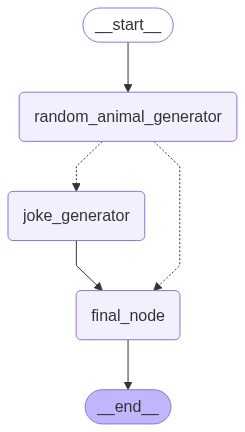

In [8]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [9]:
state = graph.invoke(input = {})

Node: Random Animal
Node: JokeNode: Joke

Node: Joke
Node: Final
Animals: ['Tiger', ' Elephant', ' Kangaroo']
Jokes: ['Why don’t tigers play cards in the jungle? Because there are too many cheetahs!', "Why do elephants never use computers? Because they're afraid of the mouse!", 'Why did the kangaroo stop drinking coffee? Because it made him jumpy!']


In [10]:
for joke in state["jokes"]:
    print(joke)

Why don’t tigers play cards in the jungle? Because there are too many cheetahs!
Why do elephants never use computers? Because they're afraid of the mouse!
Why did the kangaroo stop drinking coffee? Because it made him jumpy!
